### Load Test Data and Trained APG Sampler

In [1]:
%matplotlib inline
import os
import torch
import numpy as np
from apgs.bshape.apg_training import init_models
from apgs.bshape.affine_transformer import Affine_Transformer

CUDA = torch.cuda.is_available()
device = torch.device('cuda:1')
data_dir = '../../data/bshape/'
timesteps, num_objects, frame_pixels, mnist_pixels, num_hidden_digit, num_hidden_coor, z_where_dim, z_what_dim = 10, 2, 40, 10, 200, 200, 2, 10
data_paths = []
for file in os.listdir(data_dir + '%dobjects/test/' % num_objects):
    data_paths.append(os.path.join(data_dir, '%dobjects/test' % num_objects, file))
model_version = 'apg-bshape-num_objects=%s-num_sweeps=5-num_samples=20' % num_objects
# model_version = 'rws-bshape-num_objects=%s-num_samples=100' % num_objects

models = init_models(frame_pixels, mnist_pixels, num_hidden_digit, num_hidden_coor, z_where_dim, z_what_dim, CUDA, device, model_version, lr=None)
AT = Affine_Transformer(frame_pixels, mnist_pixels, CUDA, device)  

### Visualize Samples

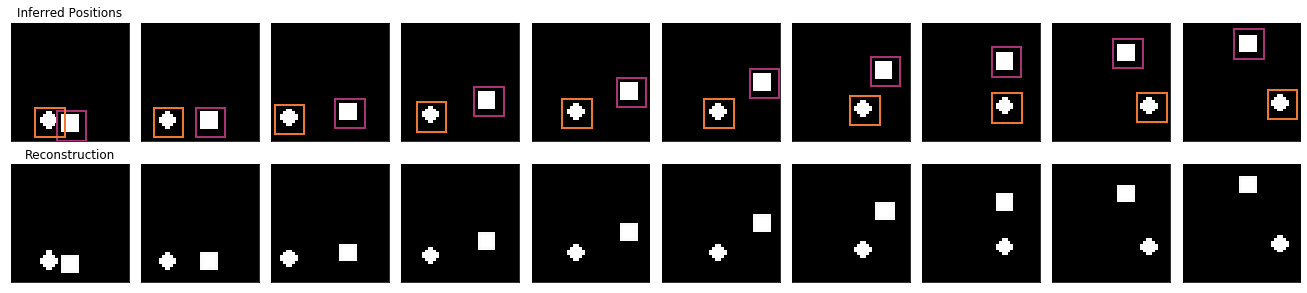

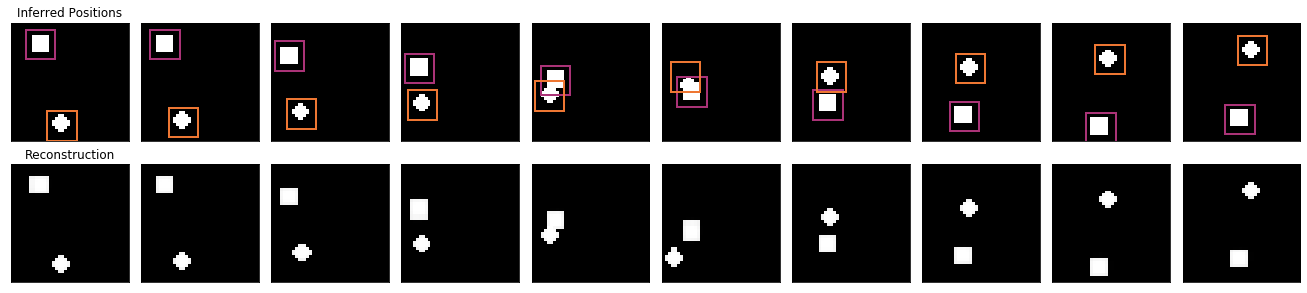

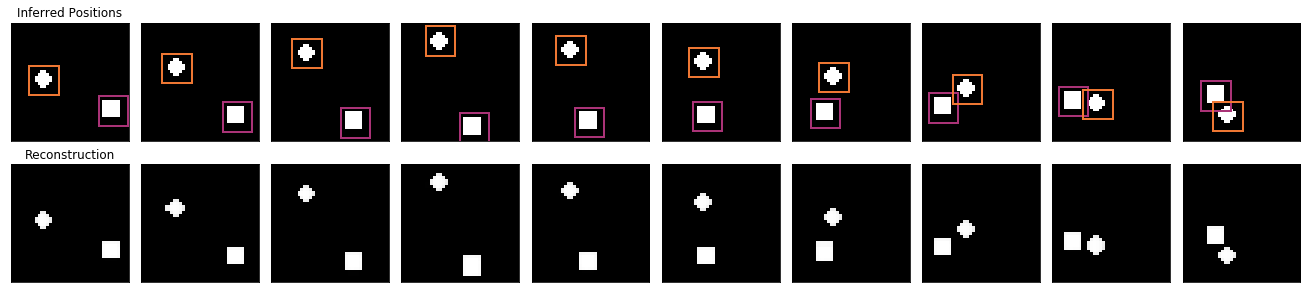

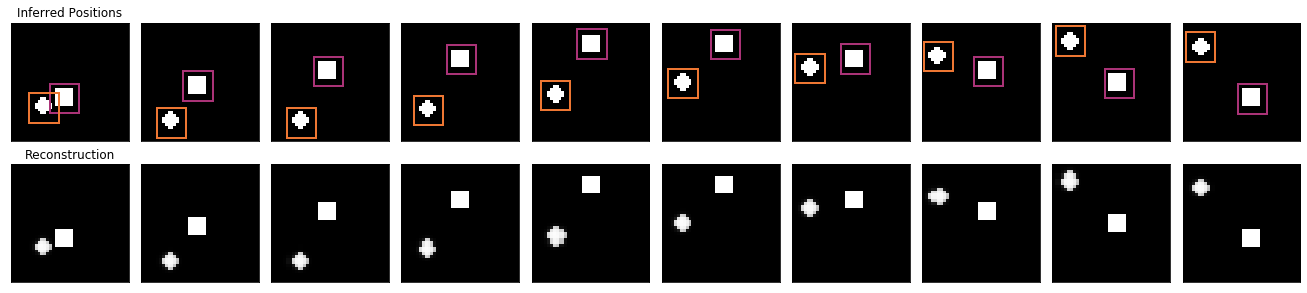

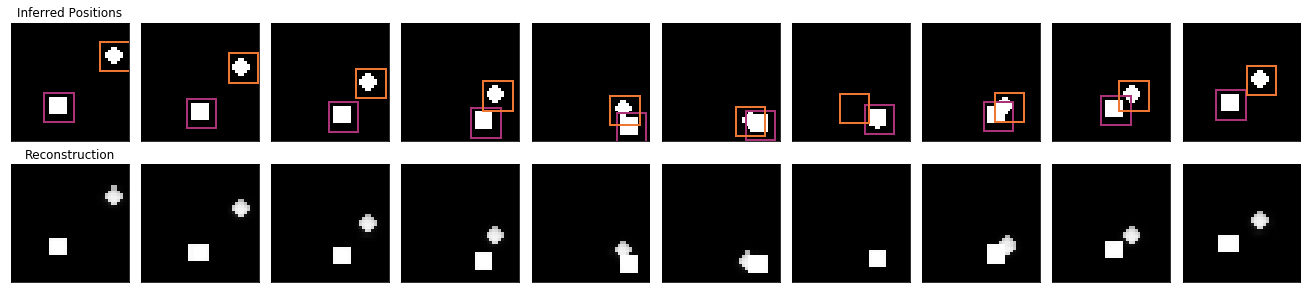

In [4]:
from apgs.resampler import Resampler
from apgs.bshape.objectives import apg_objective
from apgs.bshape.evaluation import viz_samples
from random import shuffle
batch_size, num_sweeps = 5, 10
shuffle(data_paths)
dataset = torch.from_numpy(np.load(data_paths[0])).float()
indices = torch.randperm(len(dataset))
data = dataset[indices[:batch_size]].unsqueeze(0)
shape_mean = torch.from_numpy(np.load('shape_mean.npy')).float()
shape_mean = shape_mean.repeat(batch_size, num_objects, 1, 1).unsqueeze(0)
if CUDA:
    data = data.cuda().to(device)
    shape_mean = shape_mean.cuda().to(device)
result_flags = {'loss_required' : False, 'ess_required' : False, 'mode_required' : True, 'density_required': False}
trace = apg_objective(models, AT, data, num_objects, result_flags, num_sweeps, Resampler('systematic', 1, CUDA, device), shape_mean)
viz_samples(data.squeeze(0).cpu(), trace, num_sweeps, num_objects)

### Computing log joint across all methods

In [3]:
from apgs.bshape.evaluation import density_all_instances
from random import shuffle
sample_size, num_sweeps = 100, 1
lf_step_size, lf_num_steps, bpg_factor = 1e-4, [1, 5, 10], 1
density_all_instances(models, AT, data_paths, sample_size, num_objects, z_where_dim, z_what_dim, num_sweeps, lf_step_size, lf_num_steps, bpg_factor, CUDA, device)

batch=1/5
1 / 5 completed in (1s)
batch=2/5
2 / 5 completed in (0s)
batch=3/5
3 / 5 completed in (0s)
batch=4/5
4 / 5 completed in (0s)
batch=5/5
5 / 5 completed in (0s)
method=APG(L=100, K=1), log joint=-215.93


### Computational Budget Analysis

In [ ]:
from apgs.bshape.evaluation import budget_analysis, plot_budget_analyais_results
data = torch.from_numpy(np.load(data_dir + '%dobjects/test/ob-1.npy' % num_objects)).float()
budget = 1000
num_sweeps = np.array([1, 5, 10 , 20, 25])
sample_sizes = 1000 / num_sweeps
blocks = ['decomposed', 'joint']
df = budget_analysis(models, blocks, num_sweeps, sample_sizes, data, num_objects, CUDA, device)
plot_budget_analyais_results(df)

### Comparison with Baselines

In [ ]:
from apgs.bshape.evaluation import density_convergence, plot_convergence
seed = 1
data = torch.from_numpy(np.load(data_dir + '%dobjects/test/ob-1.npy' % num_objects)).float()
sample_size, num_sweeps, num_runs = 100, 30, 3
lf_step_size, lf_num_steps, bpg_factor = 1e-1, [1, 5, 10], 100
densities = density_convergence(models, AT, data, sample_size, num_objects, num_runs, num_sweeps, lf_step_size, lf_num_steps, bpg_factor, CUDA, device)
plot_convergence(densities)